# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
CONFIG_FILE='config.yaml'


#clone report for colab
import yaml,os,sys

#setup directories
if os.name=='nt':
    pass
else:               #colab setup below
    if not os.path.exists('./repo') :
        !git clone $repo repo
        sys.path.append("repo/lib")
        sys.path.append('repo')       
    !apt update
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    
sys.path.append('lib')
# sys.path.append(LIB)

import utils
cfg=utils.setup_env(CONFIG_FILE)  #auth_file defaulted from {AUTH}/auth/yaml

for x in cfg['env'][os.name]: 
    # os.environ[x]=cfg['env'][os.name][x]
    globals()[x]=cfg['env'][os.name][x]

#need to use following for each sheet
service_account_file=f'{os.environ["AUTH"]}/{cfg["AUTH"]["service_accounts"]["indiathon"]}'

## Code

In [2]:
import yaml
import importlib
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Linkedin=socialmediasite.Linkedin

# Process
## Create headless

In [3]:
" Test Selenium headless"
if True:#'b' in globals():
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-09-22 15:20:29:INFO:Logger file: c:/m/logging/strava-automation.log


In [4]:
# %debug
# if os.name=='nt':
nerodia.default_timeout=3
li=Linkedin(b,                               #authFile=f'{AUTH}/auth.yaml'
           )
utils.setLogger(f"{LOG}/strava-automation.log")


In [5]:
li.login("avinash")

display(li.browser.url)

li.scrolldown(9)

'https://www.linkedin.com/feed/'

In [6]:

import pandas as pd

nerodia.default_timeout=.5

def getPostData(postTag):
  "Return data regarding one post in linkedin feed"
  post={}
  if not postTag.exists:
    return
  _map={
      'post':'postTag.parent().element(class_name="visually-hidden").text',
      'urn':'postTag.attributes["data_urn"]',
      'name':'postTag.element(class_name="feed-shared-actor__name").text',
      'userUrl':'postTag.link(class_name="feed-shared-actor__container-link").href',
      'likes':'postTag.element(class_name="social-details-social-counts__reactions-count").text',
        # len('.div(class_name='feed-shared-social-actions').buttons(text='Like'))',
          # 'react-button--active' in 'react-button__text--like' in 
      'liked':'"react-button--active" in postTag.div(class_name="feed-shared-social-actions").button(text="Like").class_name',
      # print(name','.element(class_name='feed-shared-social-actions'
      #                                                            ).button(text='Like').class_name)
      'text':'postTag.element(class_name="feed-shared-update-v2__commentary").text',
      'desc':'postTag.element(class_name="feed-shared-actor__description").text',
      'subdesc':'postTag.element(class_name="feed-shared-actor__sub-description").text',
      # if post['subdesc'] not in ['Promoted']:
      'deg':'postTag.span(class_name="feed-shared-actor__supplementary-actor-info").text',
  }

  for _v,_e in _map.items():
    try:
        _m = re.search(r'.*(postTag\..*\))',_e)
        if _m:
            if eval(_m.group(1)+".exists"):
                post[_v]=eval(_e,{"postTag":postTag})
    except Exception as e:
        pass
        print(f"error {e!r} {_v} {_e}")
    
    if 'text' in post : post['text']=post['text'][:40]
    if 'userUrl' in post : post['userUrl']=post['userUrl'].split("?")[0]
    # post['liked']='react-button--active' in postTag.div(class_name='feed-shared-social-actions'
    #                                                          ).button(text='Like').class_name

  return post    

def getPostIds():
  "Get list of all feed posts"
  nerodia.default_timeout=.1
  posts=[]

  for x in b.elements(class_name='feed-shared-update-v2',
                      ):#data_id=re.compile("urn:li:activity:")):
    if re.match(r"^urn:li:activity:",x.data_urn):
        try:
            post=getPostData(x)
            post.update({'el':x})
            posts.append( post)
        except Exception as e:
          # Logs the error appropriately. 
            print(f">>{e!r}")

  return posts

"list posts"
posts = getPostIds() #li.


2022-09-22 15:20:48:INFO:Logger file: c:/m/logging/strava-automation.log


## A. Give likes in feed

In [7]:
for i,p in enumerate(posts):
    # print(p['subdesc'])
    try:
        if  ('subdesc' in p) and ('Promoted' in p['subdesc']) or ('desc' in p) and ('Promoted' in p['desc']): 
            posts[i]['status']='Ads'
        elif ('deg' not in p): 
            posts[i]['status']='noDeg'
        elif '• 1st' not in p['deg']: 
            posts[i]['status']='no1Deg'
        elif p['liked']: 
            posts[i]['status']='PrvLiked'
        else:
            p['text']=p['text'] if 'text' in p else ''
            _likeButton=p['el'].div(class_name='feed-shared-social-actions'
                                  ).button(text='Like')
            if _likeButton.exists:  
                logging.info(f"Liking {p['name']} {p['text'][:30]}")
                try:
                    _likeButton.execute_script("arguments[0].click();", _likeButton)
                    posts[i]['status']='Pass'
                except Exception as e:
                  # Logs the error appropriately.
                    posts[i]['status']='Error'
                    print(f">>{e!r}")
    except Exception as e:
        print(f"{e!r} {p}")
        raise Exception


2022-09-22 15:21:14:INFO:Liking Makarand Kulkarni 
2022-09-22 15:21:14:INFO:Liking Sanket Jain Very happy to have got my sixt
2022-09-22 15:21:14:INFO:Liking Dipendra Mookherjee #ibm is ahead in the game. Whe
2022-09-22 15:21:14:INFO:Liking Nitin Manchanda Energised to deliver smiles to
2022-09-22 15:21:14:INFO:Liking Vinod Borole Thanks team Calsoft for giving
2022-09-22 15:21:15:INFO:Liking Vishvesh Borkar 
2022-09-22 15:21:15:INFO:Liking James Duggan 
2022-09-22 15:21:15:INFO:Liking Sudarshan Phatak (Sud) So proud of you !
I wish Tata 
2022-09-22 15:21:15:INFO:Liking Lt Col Sachin Tilekar (Retd) Thats a Lovely Dad .
2022-09-22 15:21:16:INFO:Liking Vishnu J Suryawanshi I am #hiring Automobile Sales 
2022-09-22 15:21:16:INFO:Liking Vinay Dharmadhikari , CSCP 
2022-09-22 15:21:16:INFO:Liking Somnath Manna #career #teamwork #supplychain
2022-09-22 15:21:17:INFO:Liking Mulchand Gala Looking forward to speaking at
2022-09-22 15:21:18:INFO:Liking Shefali Gaur (she/her) Some moments of prid

In [8]:
_df=pd.DataFrame(posts)
stats=_df.status.value_counts().to_dict()
display(stats)
_df#.query("status == 'Pass'")

{'Pass': 17, 'Ads': 8, 'no1Deg': 2, 'noDeg': 1}

,post,name,userUrl,likes,liked,desc,subdesc,deg,el,text,status
0,Feed post number 1,Makarand Kulkarni,https://www.linkedin.com/in/kulmm,19,False,Head DRA&C,6h\n6 hours ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,,Pass
1,Feed post number 2,Tata Consultancy Services,https://www.linkedin.com/company/tata-consulta...,NaN,False,Promoted,NaN,NaN,#<Div: located: True; {'class_name': 'feed-sha...,Leading pharmaceutical firm completes mu,Ads
2,Feed post number 3,Sanket Jain,https://www.linkedin.com/in/sanketjainvt,NaN,False,"Solution Manager, Senior Inventor",8h •\n8 hours ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,Very happy to have got my sixth patent f,Pass
3,Feed post number 4,Dipendra Mookherjee,https://www.linkedin.com/in/dipendra-mookherje...,8,False,Cloud and Data Solution Leader & Solution Arch...,3d •\n3 days ago,(He/Him) • 1st,#<Div: located: True; {'class_name': 'feed-sha...,#ibm is ahead in the game. When I read t,Pass
4,Feed post number 6,Impetus,https://www.linkedin.com/company/impetus/,39,True,"155,941 followers",Promoted,NaN,#<Div: located: True; {'class_name': 'feed-sha...,Leap to a cloud-native stack with LeapLo,Ads
5,Feed post number 7,Nitin Manchanda,https://www.linkedin.com/in/nitin-manchanda-45...,NaN,False,"Supply Chain Leader - Specialty Fulfilment, Am...",15h •\n15 hours ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,Energised to deliver smiles to millions,Pass
6,Feed post number 8,Vinod Borole,https://www.linkedin.com/in/vinodborole,16,False,Software Architect|Building scalable app using...,3h •\n3 hours ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,Thanks team Calsoft for giving me this o,Pass
7,Feed post number 9,Vishvesh Borkar,https://www.linkedin.com/in/vishvesh-borkar-52...,52,False,Back to school - Student @ INSAID,4d •\n4 days ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,,Pass
8,Feed post number 10,Pricefx,https://www.linkedin.com/company/price-f-x-/,39,False,"7,759 followers",Promoted,NaN,#<Div: located: True; {'class_name': 'feed-sha...,Inflation has skyrocketed.📈 What gives?,Ads
9,Feed post number 16,James Duggan,https://www.linkedin.com/in/james-duggan-pmp,13,False,"Vice President, Client Engagement, Global Serv...",5d\n5 days ago,• 1st,#<Div: located: True; {'class_name': 'feed-sha...,,Pass


In [9]:
"logout"
# li.logout()

'logout'

# test linkedin

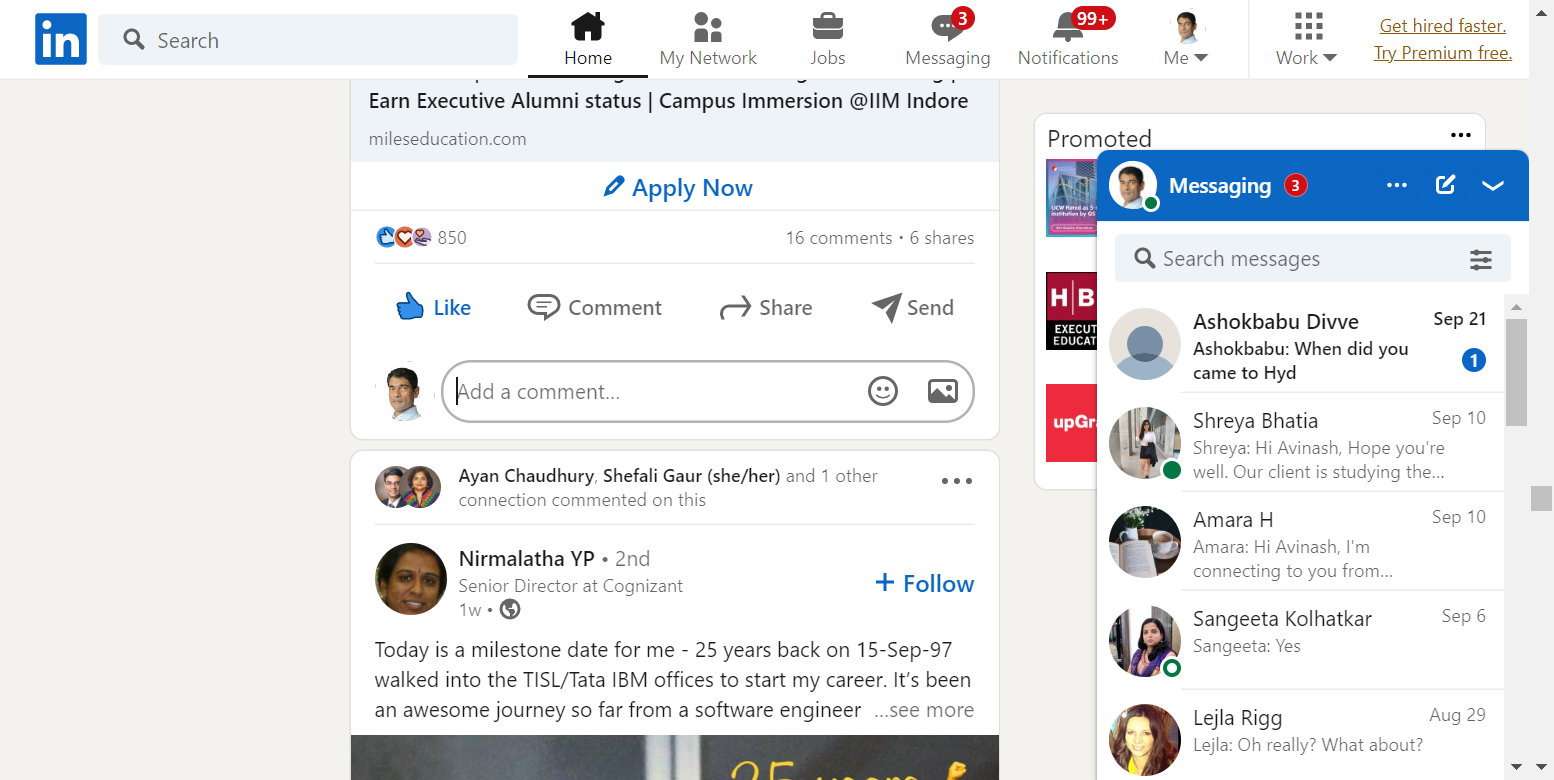

In [10]:

Image(b.screenshot.png())